<a href="https://colab.research.google.com/github/leonorafrangu/Estimate-of-pi-with-a-Poisson-process/blob/main/gender_inequality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GENDER INEQUALITY

The Gender Inequality Index (GII) dataset provides a comprehensive measure of gender inequality across countries, capturing gender disparities in health, education, and economic opportunities.
It has benn developed by the United Nations Development Programme (UNDP), who also created the GII that measures gender inequality by analyzing health, empowerment, and labor market participation indicators.

This dataset includes GII scores, as well as component scores for each indicator, for over 190 countries, in 2021.

#Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from graphviz import Source
import plotly.graph_objects as go
import random

# Data cleaning

In [ ]:
df = pd.read_csv('Gender_Inequality_Index.csv')

In [ ]:
df.shape

(195, 11)

In [ ]:
df.columns

Index(['Country', 'Human_development', 'GII', 'Rank', 'Maternal_mortality',
       'Adolescent_birth_rate', 'Seats_parliament', 'F_secondary_educ',
       'M_secondary_educ', 'F_Labour_force', 'M_Labour_force'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                195 non-null    object 
 1   Human_development      191 non-null    object 
 2   GII                    170 non-null    float64
 3   Rank                   170 non-null    float64
 4   Maternal_mortality     184 non-null    float64
 5   Adolescent_birth_rate  195 non-null    float64
 6   Seats_parliament       193 non-null    float64
 7   F_secondary_educ       177 non-null    float64
 8   M_secondary_educ       177 non-null    float64
 9   F_Labour_force         180 non-null    float64
 10  M_Labour_force         180 non-null    float64
dtypes: float64(9), object(2)
memory usage: 16.9+ KB


In [ ]:
df.head(7)

,Country,Human_development,GII,Rank,Maternal_mortality,Adolescent_birth_rate,Seats_parliament,F_secondary_educ,M_secondary_educ,F_Labour_force,M_Labour_force
0,Switzerland,Very high,0.018,3.0,5.0,2.2,39.8,96.9,97.5,61.7,72.7
1,Norway,Very high,0.016,2.0,2.0,2.3,45.0,99.1,99.3,60.3,72.0
2,Iceland,Very high,0.043,8.0,4.0,5.4,47.6,99.8,99.7,61.7,70.5
3,Hong Kong,Very high,NaN,NaN,NaN,1.6,NaN,77.1,83.4,53.5,65.8
4,Australia,Very high,0.073,19.0,6.0,8.1,37.9,94.6,94.4,61.1,70.5
5,Denmark,Very high,0.013,1.0,4.0,1.9,39.7,95.1,95.2,57.7,66.7
6,Sweden,Very high,0.023,4.0,4.0,3.3,47.0,91.8,92.2,61.7,68.0


In [ ]:
df.tail(7)

,Country,Human_development,GII,Rank,Maternal_mortality,Adolescent_birth_rate,Seats_parliament,F_secondary_educ,M_secondary_educ,F_Labour_force,M_Labour_force
188,Nir,Low,0.611,153.0,509.0,170.5,25.9,9.2,15.2,61.7,84.3
189,Chad,Low,0.652,165.0,1140.0,138.3,32.3,7.7,24.4,46.9,69.9
190,South Sudan,Low,0.587,150.0,1150.0,99.2,32.3,26.5,36.4,70.4,73.6
191,North Korea,NaN,NaN,NaN,89.0,2.3,17.6,NaN,NaN,77.2,86.1
192,Monaco,NaN,NaN,NaN,NaN,7.2,33.3,NaN,NaN,NaN,NaN
193,Nauru,NaN,NaN,NaN,NaN,72.5,10.5,NaN,NaN,NaN,NaN
194,Somalia,NaN,NaN,NaN,829.0,118.0,24.6,NaN,NaN,20.9,47.0


In [ ]:
df.isnull().sum()

Country                   0
Human_development         4
GII                      25
Rank                     25
Maternal_mortality       11
Adolescent_birth_rate     0
Seats_parliament          2
F_secondary_educ         18
M_secondary_educ         18
F_Labour_force           15
M_Labour_force           15
dtype: int64

In [ ]:
df.dropna(inplace = True)

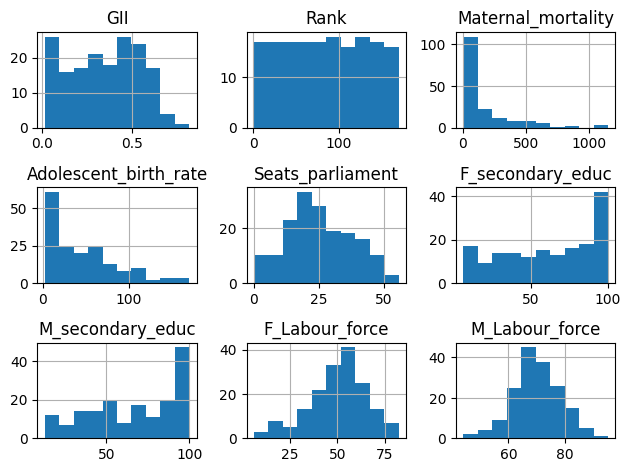

In [ ]:
df.hist()
plt.tight_layout(pad=1)

From these depictions and understanding of our variables these distributions make sense. We have high sampling of countries with lower GII (higher human development) and less countries with high GII.

#Data Analysis

In [ ]:
#Using KNN imputer to get NA values and impute them as the most similar other countries
imputer = KNNImputer(n_neighbors = 5)
#Change percent to decimal and change human development to numbers
df.Human_development.replace({'Low': 0, 'Medium': 1, 'High': 2, 'Very high': 3}, inplace = True)
df.iloc[:,5:13] = df.iloc[:,5:13].apply(lambda x: x/100)
df.Maternal_mortality = (df.Maternal_mortality / 100000)
df.Adolescent_birth_rate = df.Adolescent_birth_rate / 1000
df.head()

,Country,Human_development,GII,Rank,Maternal_mortality,Adolescent_birth_rate,Seats_parliament,F_secondary_educ,M_secondary_educ,F_Labour_force,M_Labour_force
0,Switzerland,3,0.018,3.0,0.00005,0.000022,0.398,0.969,0.975,0.617,0.727
1,Norway,3,0.016,2.0,0.00002,0.000023,0.450,0.991,0.993,0.603,0.720
2,Iceland,3,0.043,8.0,0.00004,0.000054,0.476,0.998,0.997,0.617,0.705
4,Australia,3,0.073,19.0,0.00006,0.000081,0.379,0.946,0.944,0.611,0.705
5,Denmark,3,0.013,1.0,0.00004,0.000019,0.397,0.951,0.952,0.577,0.667


This line creates an "imputer" object using the KNNImputer algorithm. KNNImputer is a method for imputing missing values that relies on the values of the nearest neighbors. In this case, n_neighbors = 5 is specified, which means that the 5 closest neighbors will be considered to impute the missing values.
Then it replaces the values in the "Human_development" column in the DataFrame. The strings 'Low', 'Medium', 'High', and 'Very high' are replaced with the numerical values 0, 1, 2, and 3, respectively.
At the end it displays the first few rows of the DataFrame with the applied transformations

In [ ]:
#Preserve the country column as categorical and get the imputer to predict the other values.
df_trans = df.set_index('Country')
df_imp = pd.DataFrame(imputer.fit_transform(df_trans), columns = df_trans.columns, index = df_trans.index)
df_imp.reset_index(inplace = True)
df_imp.describe()

,Human_development,GII,Rank,Maternal_mortality,Adolescent_birth_rate,Seats_parliament,F_secondary_educ,M_secondary_educ,F_Labour_force,M_Labour_force
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,1.800000,0.344376,85.376471,0.001572,0.000448,0.253035,0.620771,0.665465,0.503524,0.700241
std,1.117902,0.197105,49.210206,0.002341,0.000391,0.123520,0.298635,0.267456,0.153018,0.084716
min,0.000000,0.013000,1.000000,0.000020,0.000019,0.000000,0.064000,0.130000,0.060000,0.439000
25%,1.000000,0.177500,43.250000,0.000112,0.000106,0.167250,0.368750,0.442500,0.427250,0.652000
50%,2.000000,0.363000,85.500000,0.000460,0.000347,0.239500,0.692000,0.707500,0.521500,0.695500
75%,3.000000,0.505750,127.750000,0.001845,0.000654,0.345500,0.901000,0.925750,0.603750,0.753750
max,3.000000,0.820000,170.000000,0.011500,0.001705,0.557000,1.000000,1.000000,0.825000,0.955000


In summary, the code creates a new DataFrame "df_imp" from the previously modified DataFrame "df". It performs further imputation of missing values using the KNNImputer algorithm, resets the index, and calculates descriptive statistics for the numeric columns of the final DataFrame "df_imp".

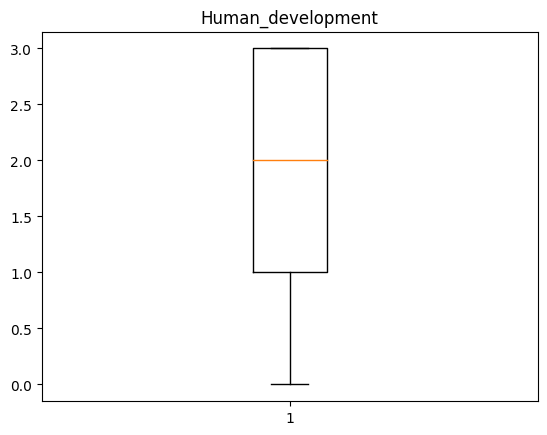

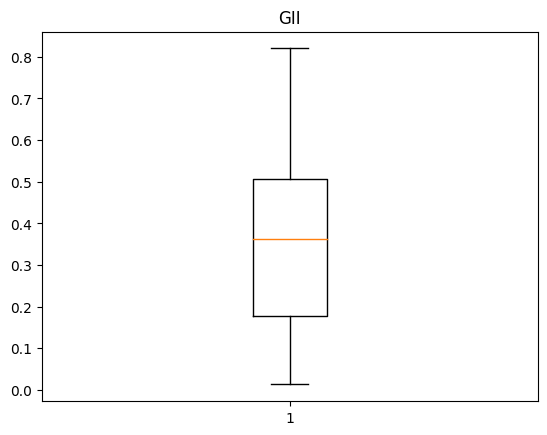

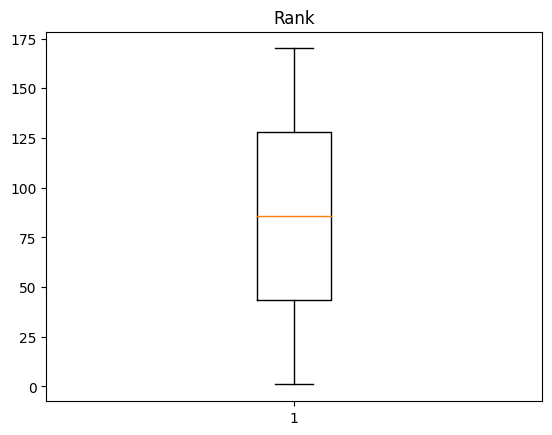

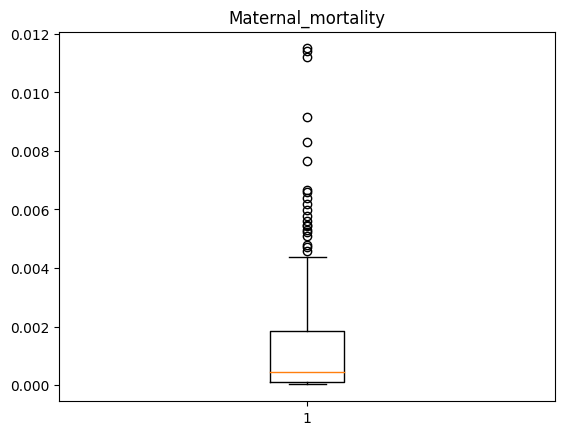

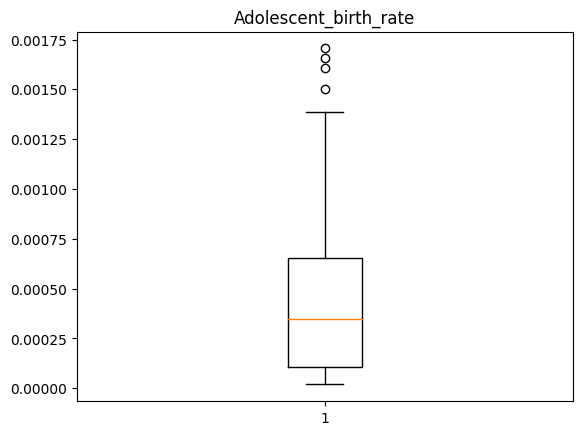

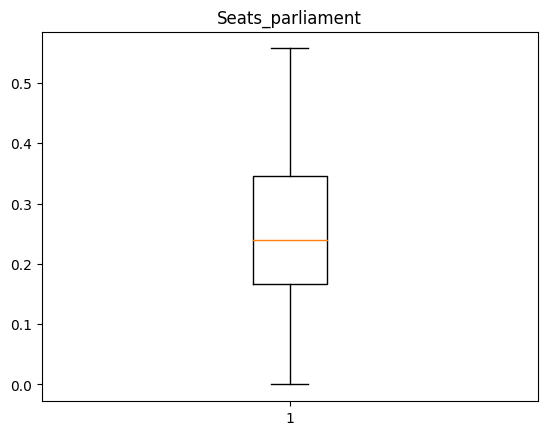

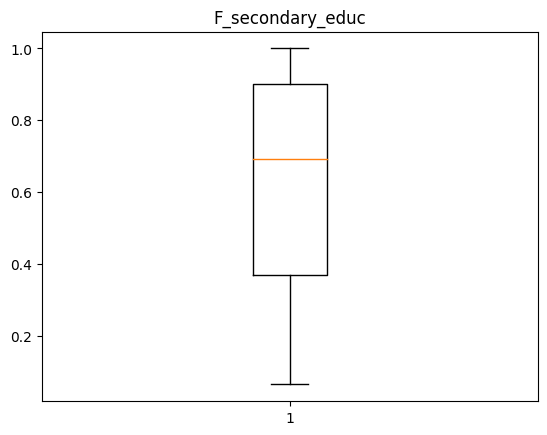

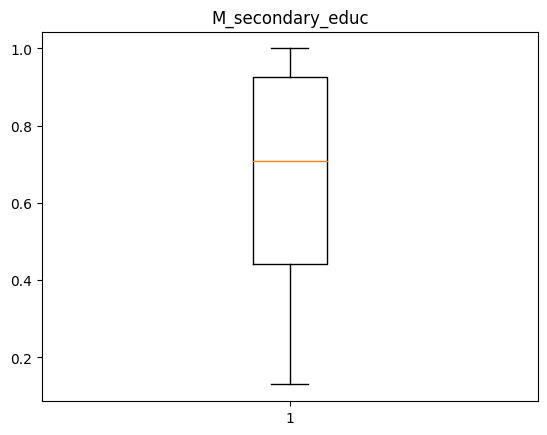

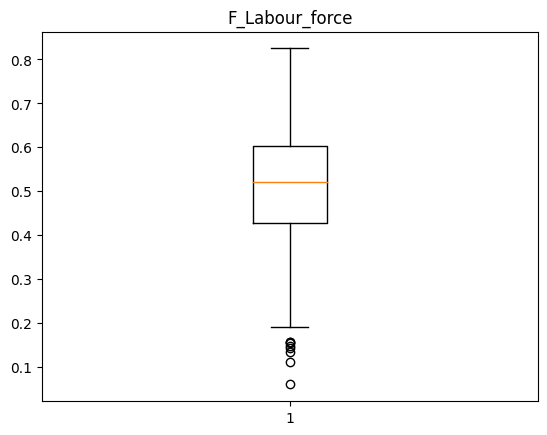

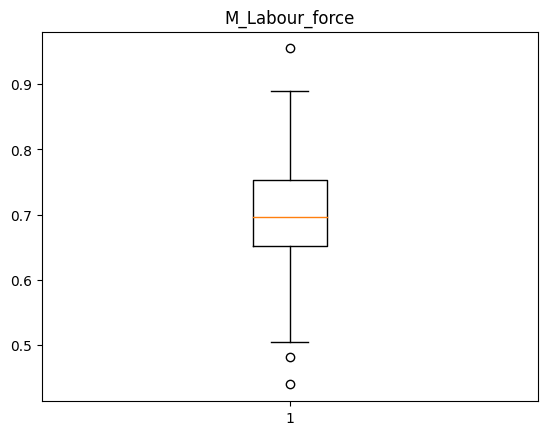

In [ ]:
for i in df_imp.columns:
    if df_imp[i].dtype != 'float64':
        pass
    else:
        plt.figure()
        plt.title(i)
        plt.boxplot(df_imp[i].values)
        plt.show()

The code generates a boxplot for each floating-point numeric column in the DataFrame "df_imp", displaying the distribution of values for each column. The boxplot is useful for identifying the symmetry of the distribution, the presence of outliers, the spread of the data, and key statistical values such as the median, quartiles, and interquartile range (IQR).

<ipython-input-228-2d3377b0c8a9>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

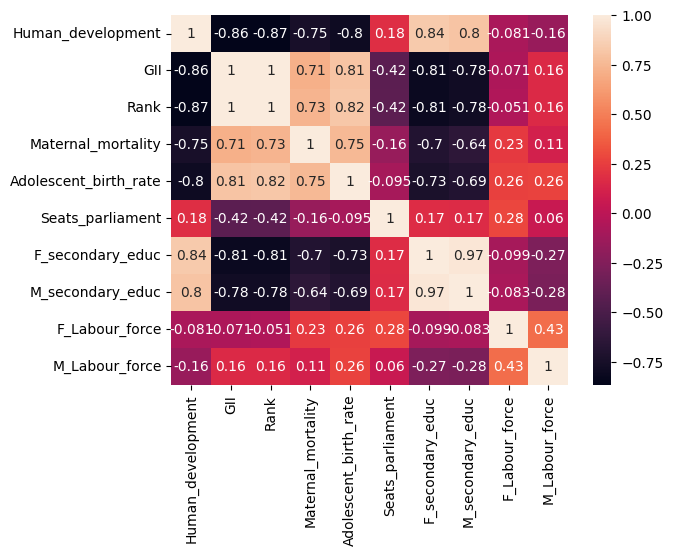

In [ ]:
y_cat = df_imp['Human_development'].replace({0:'Low', 1:'Medium', 2:'High', 3:'Very high'})
sns.heatmap(df_imp.corr(), annot = True)

In [ ]:
df_imp.corr().loc['GII']

<ipython-input-229-d51904b305a2>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Human_development       -0.861164
GII                      1.000000
Rank                     0.996755
Maternal_mortality       0.713515
Adolescent_birth_rate    0.806791
Seats_parliament        -0.424116
F_secondary_educ        -0.809278
M_secondary_educ        -0.782130
F_Labour_force          -0.070970
M_Labour_force           0.158270
Name: GII, dtype: float64

From this correlation output we see that the best predictors of GII are human development, adolescent birth rate, female and male secondary education, and maternal mortality.

In [ ]:
model = sm.OLS.from_formula('GII ~ Human_development + Adolescent_birth_rate +  F_secondary_educ + F_Labour_force + Seats_parliament', data = df_imp)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GII   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     291.4
Date:                Fri, 30 Jun 2023   Prob (F-statistic):           1.27e-79
Time:                        07:09:21   Log-Likelihood:                 230.10
No. Observations:                 170   AIC:                            -448.2
Df Residuals:                     164   BIC:                            -429.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6436      0.027     24.035      0.000       0.591       0.696
Human_development        -0.0577      0.009     -6.150      0.000      -0.076      -0.039
Adolescent_birth_rate   205.9743     22.318      9.229      0.000     161.907     250.042
F_secondary_educ         -0.1394      0.030     -4.579      0.000      -0.200      -0.079
F_Labour_force           -0.2005      0.035     -5.651      0.000      -0.271      -0.130
Seats_parliament         -0.3962      0.042     -9.372      0.000      -0.480      -0.313
==============================================================================
Omnibus:                       14.094   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.661
Skew:                           0.551   Prob(JB):                     0.000146
Kurtosis:                       4.132   Cond. No.                     1.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
y = df_imp.GII.values
X = df_imp[['Human_development', 'Adolescent_birth_rate',  'F_secondary_educ', 'F_Labour_force', 'Seats_parliament','Maternal_mortality', 'M_secondary_educ','M_Labour_force']].values
transformer = RobustScaler().fit(X)
Fit_X = transformer.transform(X)

The code prepares the dependent variable ("y") and independent variables ("X") for the regression analysis. Additionally, it applies a robust scaling transformation to the independent variables using RobustScaler, which is robust to outliers. The transformed data is assigned to the variable "Fit_X" to be used later in the regression analysis.

Robust scaler used rather than the standard scaler because we do have some outliers that make sense in the data that we want to conserve as high values

**Linear regression:**

In [ ]:
model = LinearRegression()
kf = KFold(n_splits=4, shuffle=True, random_state=0)

# iterate over the folds and train/validate the model
for train_index, test_index in kf.split(Fit_X):
    score_lis = []
    X_train, X_test = Fit_X[train_index], Fit_X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    score_lis.append(score)
    print(f'Score: {score}')
print(f'Average Score: {np.mean(score_lis)}')

Score: 0.8805147392579433
Score: 0.8160279617897892
Score: 0.9104515175381673
Score: 0.933608989063896
Average Score: 0.933608989063896


In this case adding in the other variables helps in our prediction of the GII score due to their small contribution to the explanation of variation. K-Fold Cross used to conserve data for training and testing groups and get a better feel for how the fitted model would perform when given new data.

In [ ]:
predictions = model.predict(X_test)

In [ ]:
print(df.columns)

Index(['Country', 'Human_development', 'GII', 'Rank', 'Maternal_mortality',
       'Adolescent_birth_rate', 'Seats_parliament', 'F_secondary_educ',
       'M_secondary_educ', 'F_Labour_force', 'M_Labour_force'],
      dtype='object')


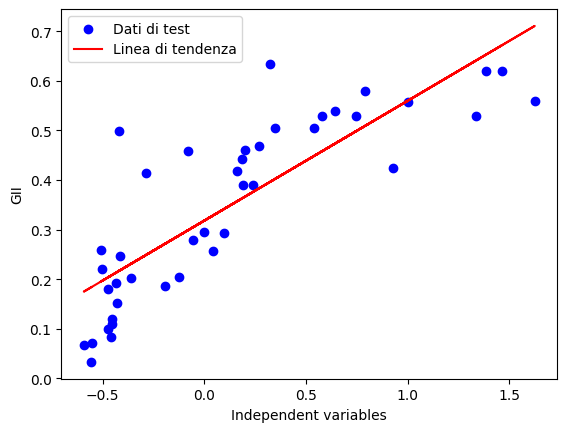

Average Score: 0.933608989063896


In [ ]:
plt.scatter(X_test[:, 1], y_test, color='blue', label='Dati di test')
plt.xlabel('Independent variables')
plt.ylabel('GII')

# Fit a linear regression line
coefficients = np.polyfit(X_test[:, 1], y_test, 1)
line = coefficients[0] * X_test[:, 1] + coefficients[1]

# Plot the regression line
plt.plot(X_test[:, 1], line, color='red', label='Linea di tendenza')

plt.legend()
plt.show()

print(f'Average Score: {np.mean(score_lis)}')

<Axes: xlabel='GII', ylabel='Rank'>

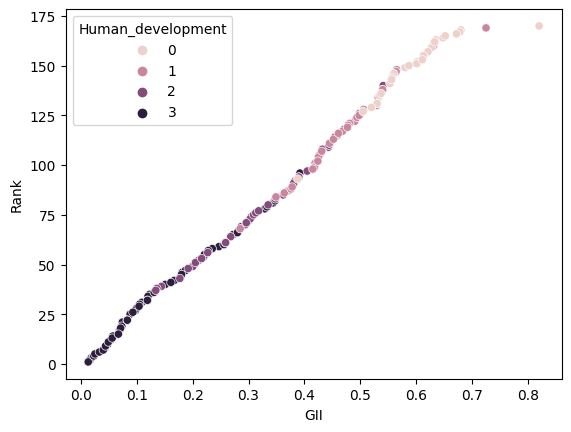

In [ ]:
sns.scatterplot(data=df,x='GII',y='Rank',hue='Human_development')

#Data Visualization

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations = df_imp['Country'],
    locationmode = 'country names',
    z = df_imp['Human_development'],
    text = df_imp['Country'],
    colorscale = 'Greens',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Human Development',
))

fig.update_layout(
    title_text='Human Development',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations = df_imp['Country'],
    locationmode = 'country names',
    z = df_imp['GII'],
    text = df_imp['Country'],
    colorscale = 'Greens',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Gender Inequality Index',
))

fig.update_layout(
    title_text='Gender Inequality Index',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

In [ ]:
# Sort the DataFrame by GII in descending order
rank = df.sort_values(by='GII', ascending=False)

# Reset the index to reflect the new ranking
rank.reset_index(drop=True, inplace=True)

# Add a new column 'Rank' to the DataFrame
rank = rank.assign(Rank=range(1, len(rank) + 1))

# Print the DataFrame with the added 'Rank' column
print(rank)

                      Country  Human_development    GII  Rank  \
0                       Yemen                  0  0.820     1   
1            Papua New Guinea                  1  0.725     2   
2                       Niria                  0  0.680     3   
3                 Afghanistan                  0  0.678     4   
4    Central African Republic                  0  0.672     5   
..                        ...                ...    ...   ...   
165               Netherlands                  3  0.025   166   
166                    Sweden                  3  0.023   167   
167               Switzerland                  3  0.018   168   
168                    Norway                  3  0.016   169   
169                   Denmark                  3  0.013   170   

     Maternal_mortality  Adolescent_birth_rate  Seats_parliament  \
0               0.00164               0.000544             0.003   
1               0.00145               0.000553             0.000   
2              

The code sorts the DataFrame "df" based on the 'GII' column in descending order, then creates a new column 'Rank' that indicates the position of each row in the ranking. Finally, it prints the DataFrame "rank" with the added 'Rank' column.

<ipython-input-242-b09011df85d0>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



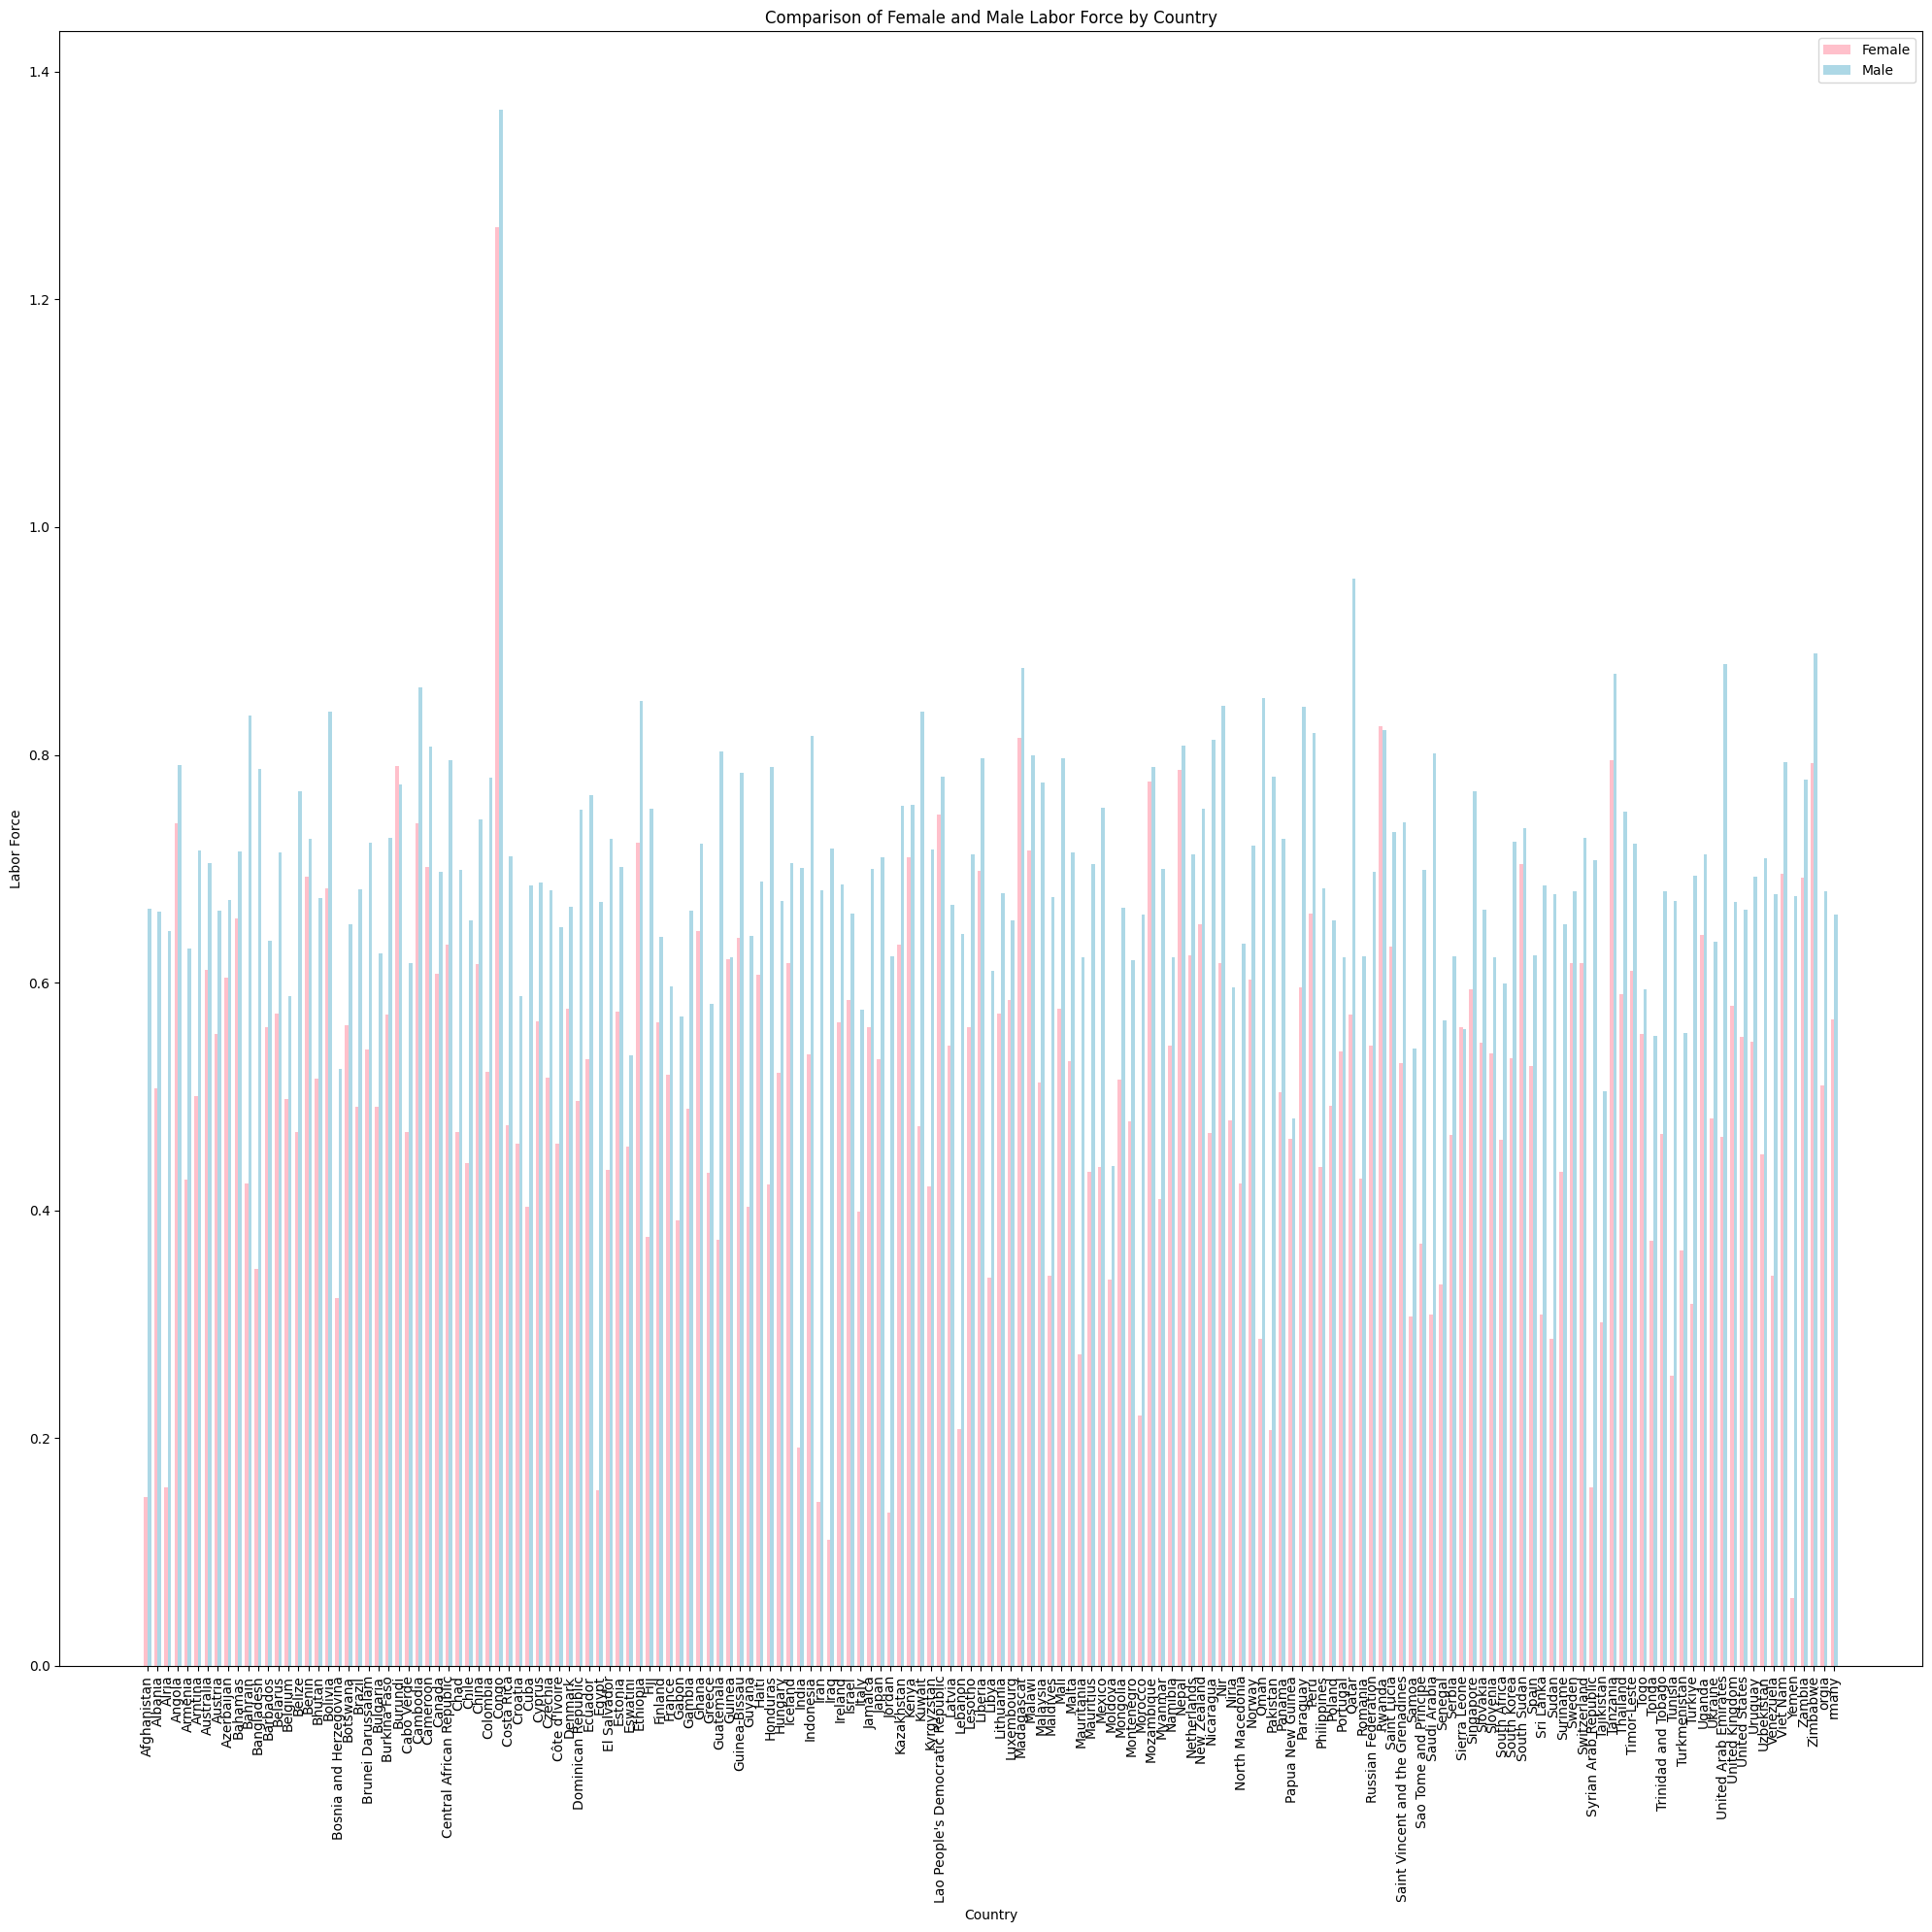

In [ ]:
# Group the data by country and calculate the sum of labor force for each gender
country_grouped = df.groupby('Country')['F_Labour_force', 'M_Labour_force'].sum()

# Get the country labels
countries = country_grouped.index.tolist()

# Get the labor force values for each gender
F_Labour_force = country_grouped['F_Labour_force']
M_labour_force = country_grouped['M_Labour_force']

# Set the bar width and positions
bar_width = 0.35
r1 = range(len(countries))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(20, 20))

# Create the grouped bar plot
plt.bar(r1, F_Labour_force, color='pink', width=bar_width, label='Female')
plt.bar(r2, M_labour_force, color='lightblue', width=bar_width, label='Male')

# Customize plot elements
plt.xlabel('Country')
plt.ylabel('Labor Force')
plt.title('Comparison of Female and Male Labor Force by Country')
plt.xticks([r + bar_width/2 for r in range(len(countries))], countries, rotation='vertical')
plt.legend()

# Adjust layout to accommodate long country names
plt.tight_layout()

# Show the plot
plt.show()

<ipython-input-243-2ab863543604>:8: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



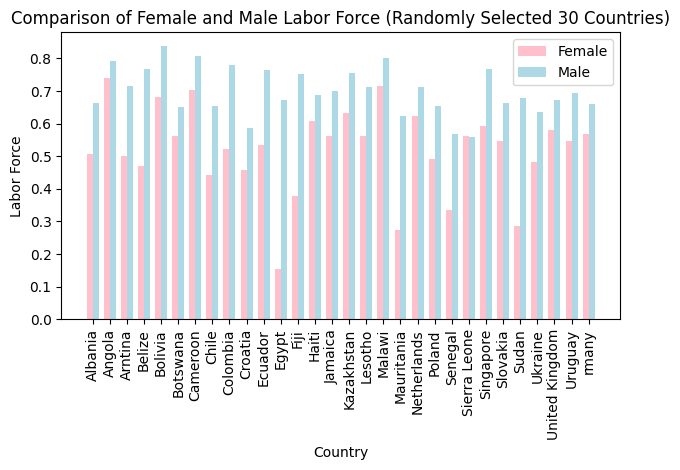

In [ ]:
# Select 30 random countries
random_countries = random.sample(df['Country'].tolist(), 30)

# Filter the data for the selected countries
selected_data = df[df['Country'].isin(random_countries)]

# Group the data by country and calculate the sum of labor force for each gender
country_grouped = selected_data.groupby('Country')['F_Labour_force', 'M_Labour_force'].sum()

# Get the country labels
countries = country_grouped.index.tolist()

# Get the labor force values for each gender
F_Labour_force = country_grouped['F_Labour_force']
M_Labour_force = country_grouped['M_Labour_force']

# Set the bar width and positions
bar_width = 0.35
r1 = range(len(countries))
r2 = [x + bar_width for x in r1]

# Create the grouped bar plot
plt.bar(r1, F_Labour_force, color='pink', width=bar_width, label='Female')
plt.bar(r2, M_Labour_force, color='lightblue', width=bar_width, label='Male')

# Customize plot elements
plt.xlabel('Country')
plt.ylabel('Labor Force')
plt.title('Comparison of Female and Male Labor Force (Randomly Selected 30 Countries)')
plt.xticks([r + bar_width/2 for r in range(len(countries))], countries, rotation='vertical')
plt.legend()

# Adjust layout to accommodate long country names
plt.tight_layout()

# Show the plot
plt.show()

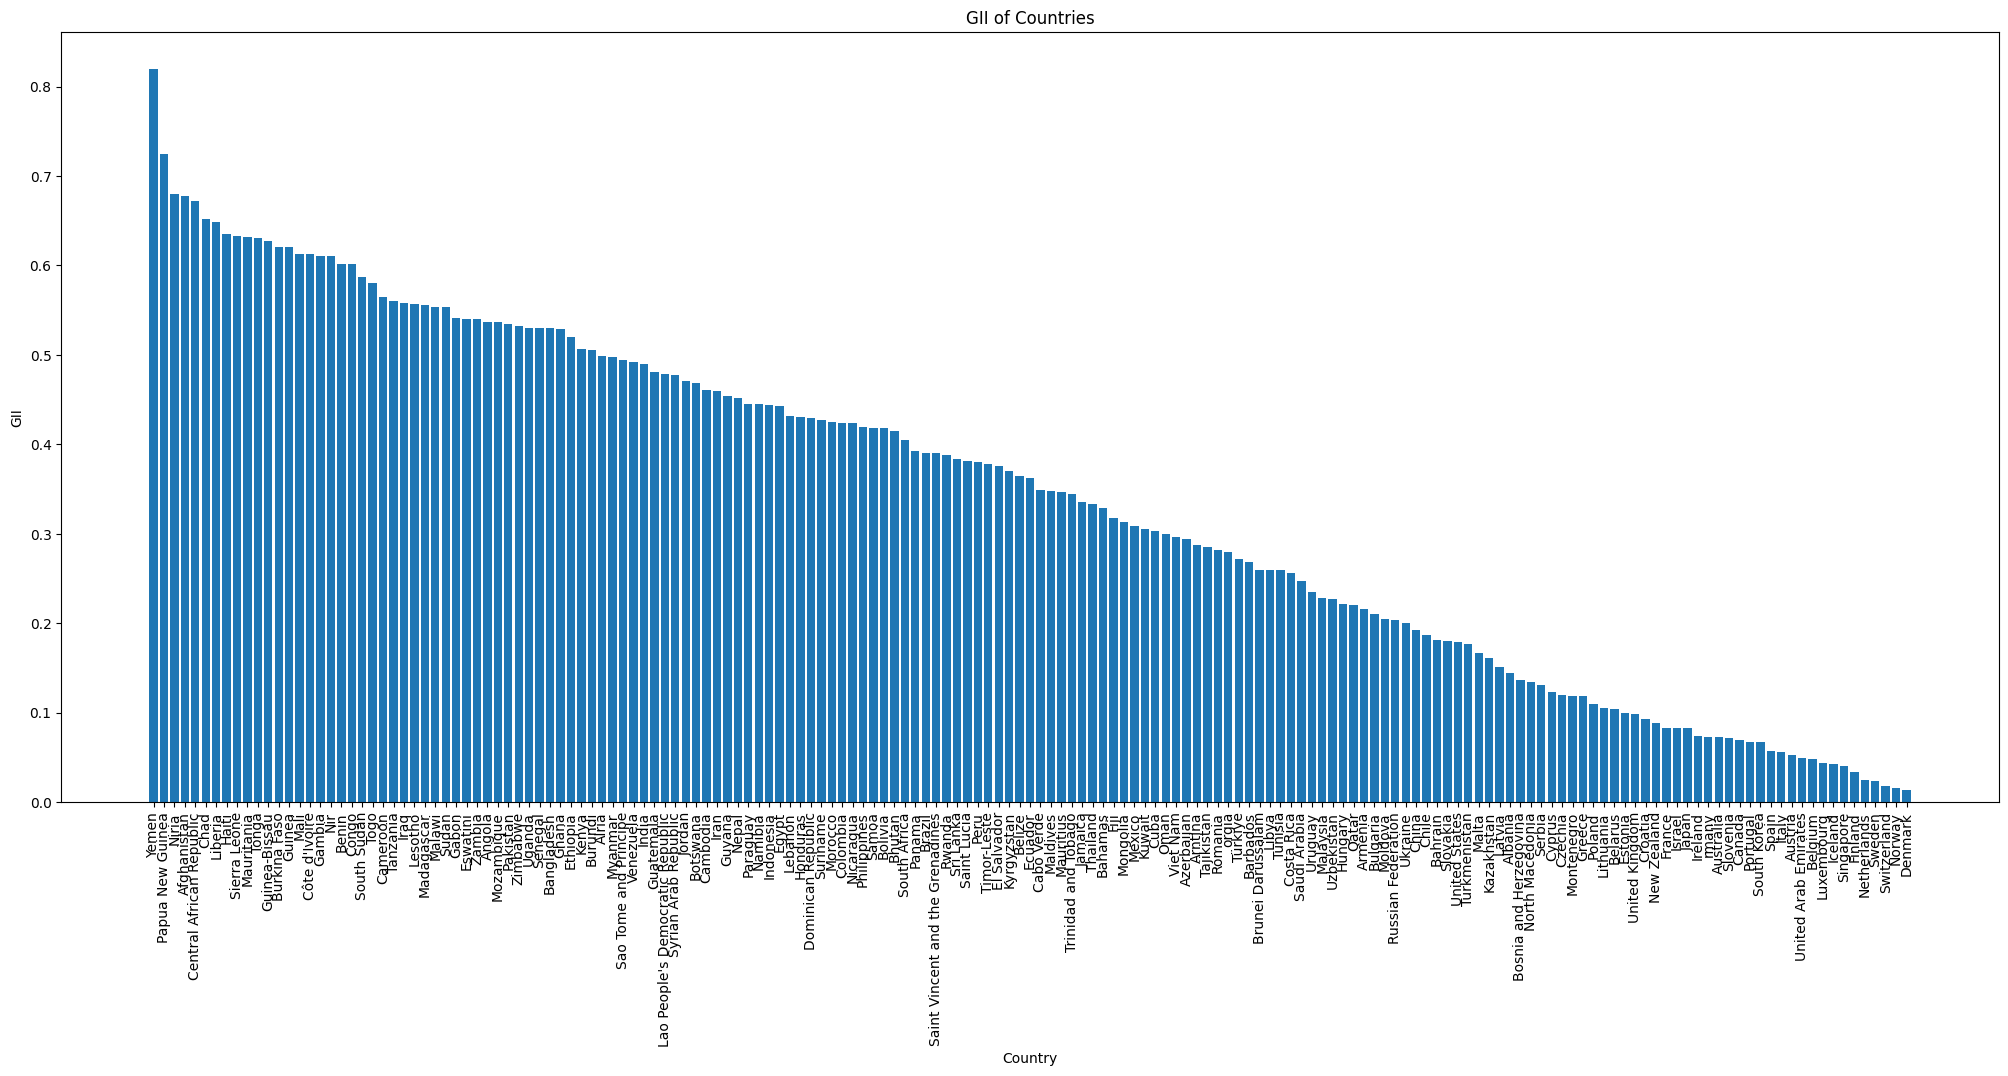

In [ ]:
# Set the figure size
plt.figure(figsize=(25, 10))

# Create the bar plot
plt.bar(rank['Country'], rank['GII'])

# Set the x-axis labels at an angle for better readability
plt.xticks(rotation=90)

# Set the axis labels and title
plt.xlabel('Country')
plt.ylabel('GII')
plt.title('GII of Countries')

# Show the plot
plt.show()

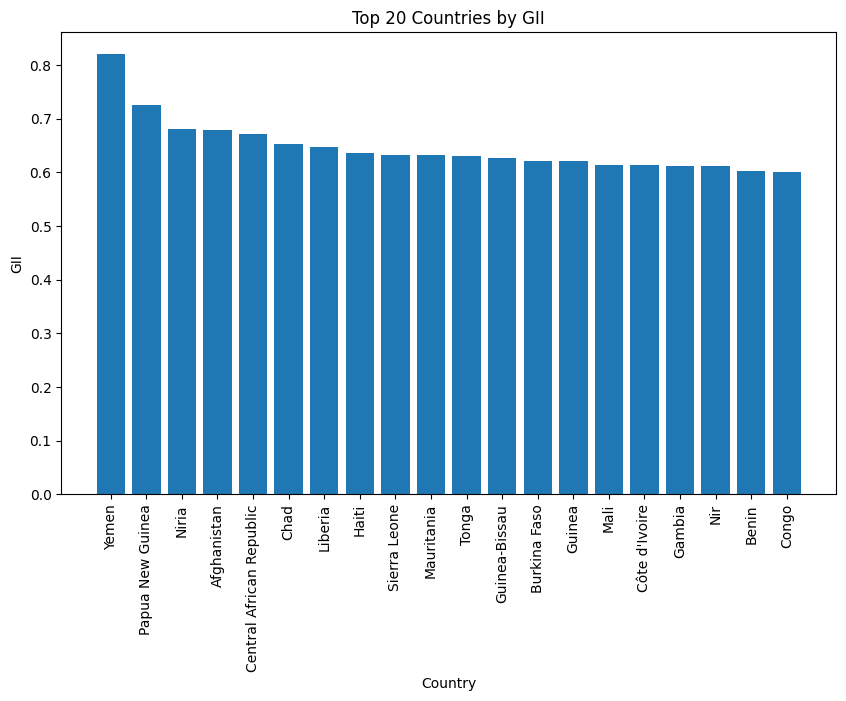

In [ ]:
top_20_rank = rank.head(20)

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the bar plot using the limited DataFrame
plt.bar(top_20_rank['Country'], top_20_rank['GII'])

# Set the x-axis labels at an angle for better readability
plt.xticks(rotation=90)

# Set the axis labels and title
plt.xlabel('Country')
plt.ylabel('GII')
plt.title('Top 20 Countries by GII')

# Show the plot
plt.show()

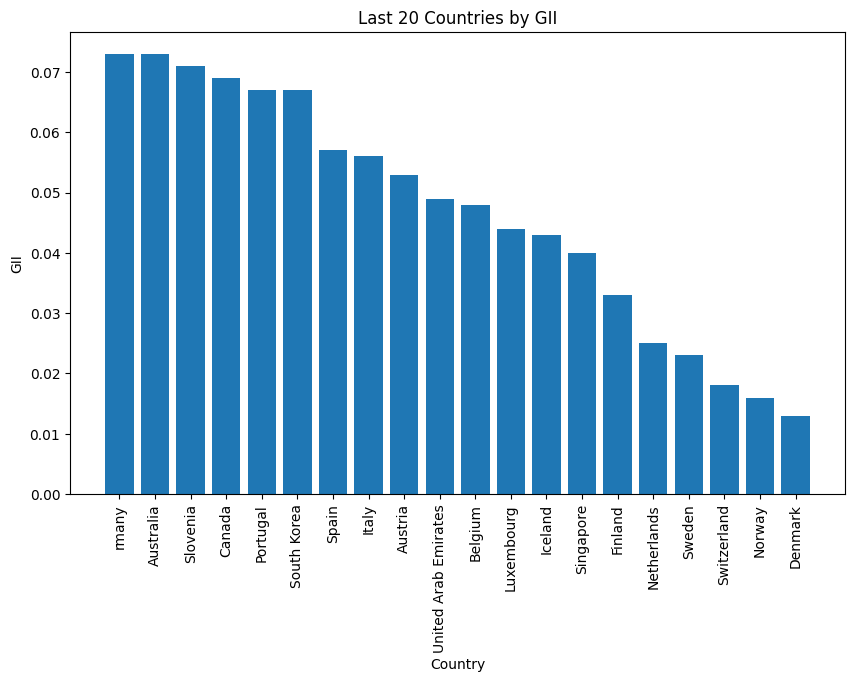

In [ ]:
topdown_20_rank = rank.tail(20)

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the bar plot using the limited DataFrame
plt.bar(topdown_20_rank['Country'], topdown_20_rank['GII'])

# Set the x-axis labels at an angle for better readability
plt.xticks(rotation=90)

# Set the axis labels and title
plt.xlabel('Country')
plt.ylabel('GII')
plt.title('Last 20 Countries by GII')

# Show the plot
plt.show()

#Predicting categorical values- GII

In [ ]:
df_imp.head()

,Country,Human_development,GII,Rank,Maternal_mortality,Adolescent_birth_rate,Seats_parliament,F_secondary_educ,M_secondary_educ,F_Labour_force,M_Labour_force
0,Switzerland,3.0,0.018,3.0,0.00005,0.000022,0.398,0.969,0.975,0.617,0.727
1,Norway,3.0,0.016,2.0,0.00002,0.000023,0.450,0.991,0.993,0.603,0.720
2,Iceland,3.0,0.043,8.0,0.00004,0.000054,0.476,0.998,0.997,0.617,0.705
3,Australia,3.0,0.073,19.0,0.00006,0.000081,0.379,0.946,0.944,0.611,0.705
4,Denmark,3.0,0.013,1.0,0.00004,0.000019,0.397,0.951,0.952,0.577,0.667


In [ ]:
df_imp.GII = df_imp.Human_development.astype(int)

**Decision Tree:**

[Text(0.6666666666666666, 0.875, 'x[0] <= 0.25\ngini = 0.73\nsamples = 170\nvalue = [30, 36, 42, 62]'),
 Text(0.5, 0.625, 'x[0] <= -0.25\ngini = 0.66\nsamples = 108\nvalue = [30, 36, 42, 0]'),
 Text(0.3333333333333333, 0.375, 'x[0] <= -0.75\ngini = 0.496\nsamples = 66\nvalue = [30, 36, 0, 0]'),
 Text(0.16666666666666666, 0.125, 'gini = 0.0\nsamples = 30\nvalue = [30, 0, 0, 0]'),
 Text(0.5, 0.125, 'gini = 0.0\nsamples = 36\nvalue = [0, 36, 0, 0]'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 42\nvalue = [0, 0, 42, 0]'),
 Text(0.8333333333333334, 0.625, 'gini = 0.0\nsamples = 62\nvalue = [0, 0, 0, 62]')]

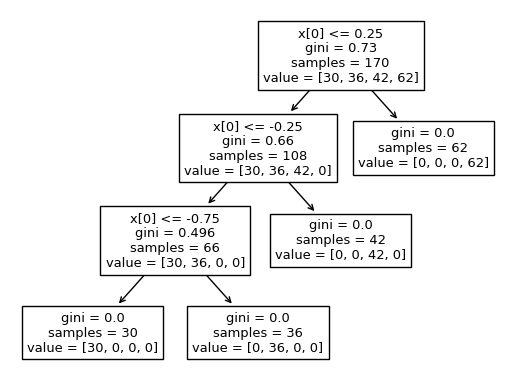

In [ ]:
Tree = tree.DecisionTreeClassifier()
X = Fit_X
y = df_imp.loc[:,'GII']
model = Tree.fit(X,y)
tree.plot_tree(model)

From this initial tree we see each tree has a 0.0 gini value meaning that the leaf is pure and contains only the values associated with that categorization

In [ ]:
TreeSplit = tree.DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
TreeSplit.fit(X_train,y_train)
pred = TreeSplit.predict(X_test)
print(f'Score of model: {r2_score(y_test,pred)}')

Score of model: 1.0


Our model scores a 1.0 meaning that all categories were sorted correctly with no confusion.

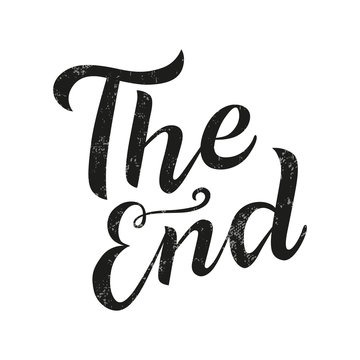